In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import cross_val_score

In [2]:
air = pd.read_csv('2008.csv')

In [3]:
air.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [4]:
air['ArrTimeDif'] = air.ArrTime - air.CRSArrTime

In [5]:
# Making new feature for arriving within 30 minutes of scheduled time.
air['LateArr'] = np.where(air.ArrTimeDif >= 30, 1, 0)

In [6]:
air.iloc[:, :14].head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90.0,78.0
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0


In [7]:
# Filling null values with 0
air = air.fillna(0)

# Restricting dataframe to include only flights that were not cancelled
air = air.loc[(air['Cancelled'] == 0)]

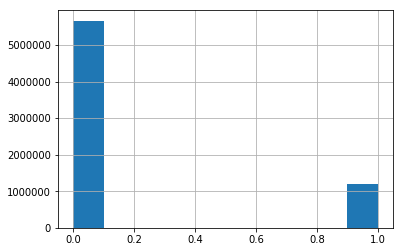

In [8]:
air['LateArr'].hist()

Data set is unbalanced.  Let's use undersampling of on-time flights to balance the data.

In [9]:
# Creating new dataframe utilizing undersampling of on-time flights
ontime = air[air.LateArr == 0]
late = air[air.LateArr == 1]
ontime_subsamp = ontime.loc[np.random.choice(ontime.index, 1210345, replace=False)]
air2 = pd.concat([late, ontime_subsamp])

In [10]:
# Adding features
air2 = air2[['LateArr', 'DepTime', 'Month', 'DayOfWeek',
       'UniqueCarrier', 'FlightNum', 'AirTime', 'Origin',
       'Distance', 'TaxiIn', 'TaxiOut', 'Dest',
       'Diverted', 'CarrierDelay', 'WeatherDelay',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]
carriers = pd.get_dummies(air2['UniqueCarrier'])
months = pd.get_dummies(air2['Month'], prefix='Month')
days = pd.get_dummies(air2['DayOfWeek'], prefix='Day')
#origins = pd.get_dummies(air2['Origin'], prefix='Orig') --dropped due to memory constraints
#destinations = pd.get_dummies(air2['Dest'], prefix='Dest') --dropped due to memory constraints
air2 = air2.join(carriers, how='right')
air2 = air2.join(months, how='right')
air2 = air2.join(days, how='right')
#air2 = air2.join(origins, how='right') --dropped due to memory constraints
#air2 = air2.join(destinations, how='right') --dropped due to memory constraints
air2 = air2.drop(['UniqueCarrier', 'Month', 'DayOfWeek', 'Origin', 'Dest'], axis=1)

In [12]:
air2

,LateArr,DepTime,FlightNum,AirTime,Distance,TaxiIn,TaxiOut,Diverted,CarrierDelay,WeatherDelay,...,Month_10,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7
2,1,628.0,448,76.0,515,3.0,17.0,0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,1,1829.0,3920,77.0,515,3.0,10.0,0,2.0,0.0,...,0,0,0,0,0,0,1,0,0,0
6,1,1937.0,509,230.0,1591,3.0,7.0,0,10.0,0.0,...,0,0,0,0,0,0,1,0,0,0
11,1,1644.0,1333,107.0,828,6.0,8.0,0,8.0,0.0,...,0,0,0,0,0,0,1,0,0,0
19,1,1416.0,54,49.0,220,2.0,5.0,0,12.0,0.0,...,0,0,0,0,0,0,1,0,0,0
26,1,1422.0,188,143.0,1093,6.0,6.0,0,40.0,0.0,...,0,0,0,0,0,0,1,0,0,0
30,1,2107.0,362,134.0,972,6.0,7.0,0,5.0,0.0,...,0,0,0,0,0,0,1,0,0,0
37,1,1812.0,422,118.0,765,6.0,11.0,0,3.0,0.0,...,0,0,0,0,0,0,1,0,0,0
48,1,1450.0,3244,121.0,888,7.0,8.0,0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
49,1,2245.0,186,59.0,359,3.0,7.0,0,282.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [13]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()

y = air2['LateArr']
X = air2.drop(['LateArr'], axis=1)

# Fit the model.
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
pred_y = rfc.predict(X)

print('\n Percentage accuracy')
print(rfc.score(X, y))

print('\n Percentage of late flights identified')
tabr = (pd.crosstab(pred_y, y))
print(tabr.loc[1, 1] / (tabr.loc[0, 1] + tabr.loc[1, 1]))


 Percentage accuracy
0.9916090040443014

 Percentage of late flights identified
0.9854545604765583


In [16]:
cross_val_score(rfc, X, y, cv=5)

array([0.46823426, 0.5019891 , 0.5489158 , 0.53018148, 0.48445898])

The random forest classifier scored well by accuracy.  However, it is overfitting to a significant degree.  Let's try a different classifier.

In [18]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

y = air2['LateArr']
X = air2.drop(['LateArr'], axis=1)

knn.fit(X, y)

print('\n Percentage accuracy')
print(knn.score(X, y))

pred_y = knn.predict(X)

print('\n Percentage of late flights identified')
tabr = (pd.crosstab(pred_y, y))
print(tabr.loc[1, 1] / (tabr.loc[0, 1] + tabr.loc[1, 1]))


 Percentage accuracy
0.9371790687779105

 Percentage of late flights identified
0.9164543993654701


In [19]:
cross_val_score(knn, X, y, cv=5)

array([0.84786776, 0.85894518, 0.87638235, 0.86044681, 0.81064696])

The KNN classifier scored as 93.7% accurate in predicting the on-time arrival status of different flights.  This was lower than the random forest classifier, but the KNN classifier performed immensely better in cross-validation.  Therefore, the KNN classifier is not overfitting nearly as much, and is a significantly better model.